In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings

# add workspace directory to the path so we
# can import from .py files theree 
sys.path.insert(1, '/data/workspace_files/')
from models import EWMAModel

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
SENT_DIR = '/data/workspace_files/RoBERTa Sentiment Scores'
DATA_DIR = '/data/workspace_files/BTC and ETH Price Data'

### High Volatility Periods

In this notebook, we examine how the RandSent Index performs during the COVID-19 crash. Additionally, we randomly sample positive, negative, and neutral tweets for inclusion in the report for illustrative purposes.

First, we load the data and recreate the RandSent Index, using $\alpha=0.0015$ as determined in the **Sentiment Indices and Dataset Compilation** notebook.

In [3]:
# load the price and volatility data for some basic visualization/exploration
data = pd.read_csv(os.path.join(DATA_DIR, 'price_return_vol_data.csv'),
                   index_col='Date', parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BTC Price         2039 non-null   float64
 1   BTC Return        2039 non-null   float64
 2   BTC Realized Vol  2038 non-null   float64
 3   ETH Price         2039 non-null   float64
 4   ETH Return        2039 non-null   float64
 5   ETH Realized Vol  1836 non-null   float64
dtypes: float64(6)
memory usage: 111.5 KB


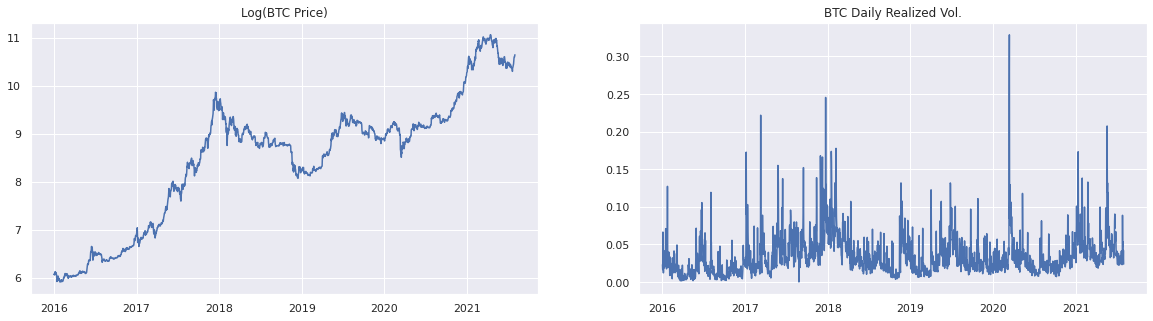

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(np.log(data['BTC Price']))
ax[0].set_title('Log(BTC Price)')

ax[1].plot(data['BTC Realized Vol'])
ax[1].set_title('BTC Daily Realized Vol.')

plt.show()

In [5]:
# update this file to point to the desired sentiment dataset
sent_file = os.path.join(SENT_DIR, 'scores_twitter_roberta_pretrained_random_all.csv')

sent_data = pd.read_csv(sent_file, encoding='utf-8', 
                        index_col=0, parse_dates=['created_at'])
sent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4826627 entries, 880954010085322752 to 1233900877427044352
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   created_at  datetime64[ns]
 1   clean_text  object        
 2   score       float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 147.3+ MB


In [6]:
# create the sentiment series
sentiment = sent_data.loc[:, ['created_at', 'score']]
sentiment.set_index('created_at', drop=True, inplace=True)
sentiment = sentiment.sort_index().squeeze()

In [7]:
# same alpha determined in the Sentiment Indices and Dataset Compilation
# notebook
alpha = 0.0015
sentiment_model = EWMAModel(alpha)
sent_index = sentiment_model.predict(x=sentiment).resample('D').last()

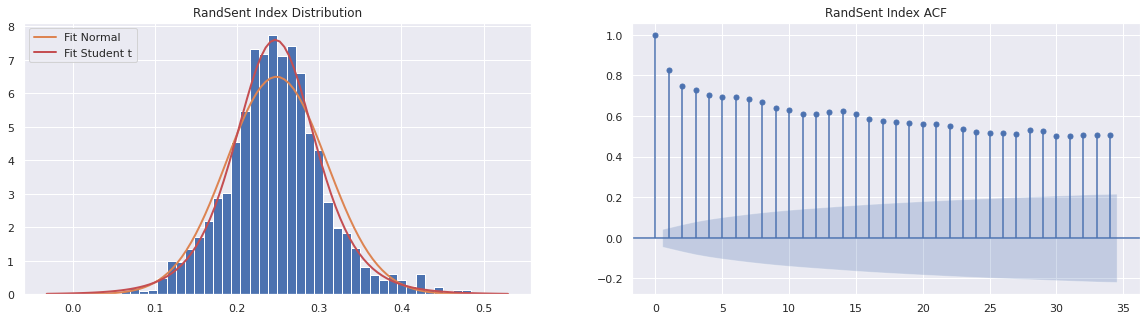

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].hist(sent_index, bins=50, density=True)

x = np.linspace(sent_index.min(), sent_index.max(), 100)
ax[0].plot(x, stats.norm.pdf(x, *stats.norm.fit(sent_index)), 
           label='Fit Normal', linewidth=2)
ax[0].plot(x, stats.t.pdf(x, *stats.t.fit(sent_index)), 
           label='Fit Student t', linewidth=2, color='r')
ax[0].legend(loc='upper left')
ax[0].set_title('RandSent Index Distribution')

plot_acf(sent_index, ax=ax[1], title='RandSent Index ACF')

plt.show()

In [9]:
sent_index.mean(), sent_index.std()

(0.24783811294934527, 0.06141238242325147)

In [10]:
def get_period(df, start, end):
    """Helper function for getting data by period from a DataFrame."""
    return df.loc[(df.index >= start) & (df.index <= end)]

def plot_period_summary(sent_index, rvol, price, start, end, ax=None):
    """Plot the sentiment index, realized volatility, and price 
    for a given period.
    """
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    sent_index = get_period(sent_index, start, end)
    rvol = get_period(rvol, start, end)
    price = get_period(price, start, end)

    ax[0].plot(sent_index, label='Sentiment Index')
    ax[0].plot(rvol, label='Realized Volatility')
    ax[0].legend(loc='upper left')
    ax[0].set_title('Sentiment vs. Realized Volatility')

    ax[1].plot(price)
    ax[1].set_title('Price')

def get_sent_data(df, date):
    """Helper function for getting sentiment data for a single day."""
    start = pd.to_datetime(date)
    end = start + pd.DateOffset(days=1)

    return df.loc[(df['created_at'] >= start) & 
                  (df['created_at'] < end), :]

def tweets_to_latex(tweets):
    """Convert DataFrame of tweets to a Latex table for the report."""
    tweets = tweets.loc[:, ['score', 'clean_text']]
    with pd.option_context('max_colwidth', None):
        print(tweets.to_latex(index=False, header=False, 
                            float_format='{:.4f}'.format, 
                            column_format='l'))

The graph below presents the RandSent Index, Bitcoin realized volatility, and Bitcoin prices for the COVID-19 crash. We discuss this graph and our findings in detail in the report.

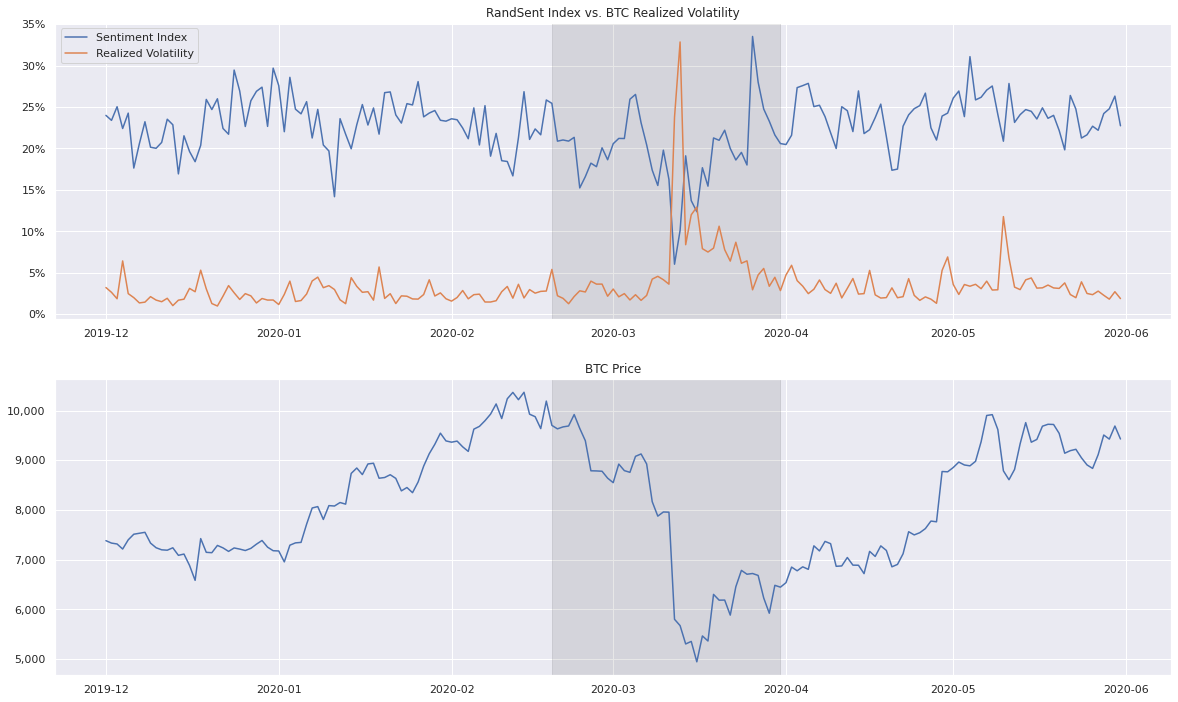

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
plot_period_summary(sent_index, data['BTC Realized Vol'], data['BTC Price'], 
                    '2019-12-01', '2020-05-31', ax=ax)

# 2020 COVID crash
dates = (pd.to_datetime('2020-02-19'), pd.to_datetime('2020-03-31'))
ax[0].axvspan(*dates, color='k', alpha=0.1)
ax[1].axvspan(*dates, color='k', alpha=0.1)

ax[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

ax[0].set_title('RandSent Index vs. BTC Realized Volatility')
ax[1].set_title('BTC Price')

# save for report
fig.savefig('covid_period.png')
plt.show()

We randomly select 10 tweets from March 12, 2020 for inclusion in the report.

In [46]:
covid_crash = get_sent_data(sent_data, '2020-03-12')
tweets_to_latex(covid_crash.sort_values('score').head(100).sample(10, random_state=1))

\begin{tabular}{l}
\toprule
-0.7811 &                                                                                                                                                       Bitcoin has proven no haven for investors, plunging 30\% from its most recent peak in Febr as global markets were roiled by increasing headwinds, chart  @user   http  \\
-0.7724 &                                               cryptocurrency markets ( btc  eth) have crashed along with the stock markets. I would have predicted the opposite, that investors would see crypto is a safe haven during a collapse of financial systems. Much like gold.  So why did cryptos tank even worse than than dow? \\
-0.8716 &                                                                                                                                                                           Wrath of Corona, who would have thought that it will have such a devastating effect on world economy.  CoronavirusPandemic  Covid19  

Positive, negative, and neutral tweets for the appendix are included below.

In [34]:
tweets_to_latex(sent_data.loc[sent_data['score'] > 0.5].sample(10, random_state=1))

\begin{tabular}{l}
\toprule
0.5149 & Pi is a new digital currency being developed by a group of Stanford PhDs. For a limited time, you can join the beta to earn Pi and help grow the network...  To join Pi, follow this link  http and   use my username (Pesamob) as your invitation code.  Bitcoin  http  \\
0.5959 &                                                                                                                                                                                                         Market cap just crossed \$100B  http bitcoin  blockchain  fintech \\
0.7894 &                                                                                                                                                  TechCrunch Hackathon Reveals The Power Of Hashgraph: Fast, Usable \&amp; Decentralized Apps Created In…  xbt  btc  http  \\
0.9074 &                                                                                                                                   

In [37]:
tweets_to_latex(sent_data.loc[sent_data['score'] < -0.5].sample(10, random_state=12))

\begin{tabular}{l}
\toprule
-0.5004 &                                                                                                                                                                                                            ‘I Forgot My PIN’: An Epic Tale of Losing \$30,000 in  Bitcoin | WIRED  http  \\
-0.5778 &                                                                                                                                                      Francesco Molinari is still searching for the game he lost at Augusta National  http play\_button   http Bitcoin  Sportsbook  http  \\
-0.8666 &                                                                                                                                                                                                                                                               Fiat is the shitcoin  BTC \\
-0.5169 &                                                                                  

In [40]:
tweets_to_latex(sent_data.loc[(sent_data['score'] > -0.1) &
                              (sent_data['score'] < 0.1)].sample(10, random_state=123))

\begin{tabular}{l}
\toprule
 0.0517 &                                                                                                                    Bitcoin Price Watch; Breakout and Intra-Range Update  http fintech  bitcoin \\
 0.0783 &                                                                                                                       Bitcoin Mining Contract 3.5 TH/s +/- 10\% for 7 days  http bitcoin  http  \\
-0.0513 &                                                                                                                         SEC to Bitcoin Investment Trust: 'cease and desist'  http btc  bitcoin \\
 0.0817 & Top 5  cryptocurrencies   Alert Time: 2019-10-19 03:40:02  Bitcoin: \$7,960.545  Ethereum: \$172.908  XRP: \$0.292  Tether: \$1.005  BitcoinCash: \$212.257  binance \$USD \$EUR \$QRL \$BTCUSD   http  \\
 0.0440 &                                                                                                                   Antminer S9 13.5 TH/s 